In [1]:
#Importing required modules
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from csv import writer

In [2]:
def EV_data(EV, H):
    EV_info = []
    for k in range(EV):
        Arrival = random. randint(0, H-1)
        Deadline = random.randint(Arrival, H-1)
        Energy_demand = random.randint(20, (Deadline-Arrival+1)*60)

        EV_info.append([Arrival, Deadline, Energy_demand])
    return EV_info

In [3]:
# Inputs

# Instance = [[1, 3, 73], [8, 8, 131], [6, 8, 99], [0, 1, 71], [2, 6, 149], [6, 9, 190], [2, 8, 100], 
#             [1, 9, 116], [1, 3, 103], [7, 9, 155]]
Instance = [[5, 8, 36], [0, 9, 53], [9, 9, 33], [4, 5, 61], [2, 3, 132], [7, 7, 54], [0, 0, 37], [7, 7, 198],
            [5, 7, 34], [2, 6, 181], [7, 8, 48], [5, 6, 112], [5, 9, 20], [3, 4, 174], [8, 8, 138], [5, 8, 36],
            [8, 8, 183], [3, 5, 125], [9, 9, 112], [8, 8, 134], [7, 8, 153], [9, 9, 109], [4, 7, 157], 
            [8, 9, 39], [0, 8, 70], [0, 4, 75], [9, 9, 37], [3, 9, 84], [7, 8, 122], [8, 8, 124]]
#             , [2, 2, 109],
#             [9, 9, 162], [3, 4, 131], [8, 8, 83], [0, 2, 96], [2, 7, 157], [5, 8, 78], [4, 4, 96], [2, 3, 28],
#             [1, 6, 45]]

N = 500 #Population size

R_fast = 60
R_slow = 20
W_penalty = -1
D_penalty = -2

ports = 10

F = R_fast
S = R_slow
W = W_penalty
D = D_penalty

sp_fast = 1.31 # selling price for fast charging
sp_slow = 1.11 # selling price for slow charging

# variables 'alpha', 'beta' for calculating customer satisfaction:
alpha = 1
beta = 1

HEIGHT = 30 #No. of EVs
WIDTH = 10 #No. of time slots

# Instance = EV_data(HEIGHT, WIDTH)

In [4]:
# Pick an option randomly
def pickReward(pick):
    return random.choice(pick)

In [5]:
def pricing_Model(E):
    gridPrice = (E*E)/1000
    return gridPrice

In [6]:
def expectedSlots(c1, c2):
    
    a = np.array([[R_fast,R_slow], [1, 1]])
    b = np.array([c1, c2])
    x = np.linalg.solve(a, b)
    return x

In [7]:
def checkPortsConstraint(X):
    X = np.transpose(X)
    for t,T in enumerate(X):
        occurances = sum(T == R_fast) + sum(T == R_slow)
        if (occurances > ports):
            return t
    return -1 # Here -1 means ports constraint is satisfied

In [8]:
def generateSolutions():
#     Define options to pick from
    pick = [R_fast, R_slow, W_penalty, D_penalty]
    X = []
    
    for k in range(HEIGHT):
        each_k = []
        total = 0
        for t in range(WIDTH):
            picked = pickReward(pick)
            
            if t < Instance[k][0]: # If 't' is before Arrival time, choose 0
                picked = 0
                each_k.append(picked)
            if t == Instance[k][0]: # If 't' is at the time of arrival, choose something
                each_k.append(picked)
            if t > Instance[k][1]: # If 't' is after the deadline, choose 0
                picked = 0
                each_k.append(picked)
            elif(t > Instance[k][0] and t <= Instance[k][1]): # If 't' is within the arrival and deadline
                
#         Add constraints
#         1. Find the total energy fulfilled, assign 0 if demand fulfilled
                if (each_k[t-1] == R_fast or each_k[t-1] == R_slow):
                    total = total + each_k[t-1]
            
                if (total >= Instance[k][2]):
                    picked = 0
                    each_k.append(picked)
                    
#         2. If 'D' is chosen, the rest of the time slots should be 0
                elif(each_k[t-1] == D_penalty or each_k[t-1] == 0):
                    picked = 0
                    each_k.append(picked)
                else:
                    each_k.append(picked)
                    
#         3. Not exceeding the total number of ports 
        X.append(each_k)
        while(checkPortsConstraint(X) != -1): # This means the ports are occupied
            idx = checkPortsConstraint(X)
            X[k][idx] = pickReward([W_penalty, D_penalty])
            if X[k][idx] == D_penalty:
                for i in range(idx+1, Instance[k][1]+1):
                    X[k][i] = 0
#     X = np.array(X)
               
    return X

In [9]:
def calculateRevenue(Allocation_table):
    Allocation_table = np.array(Allocation_table)
#     print("Alloc:",Allocation_table)
    
#     Transpose of Allocation table
    Allocation_table = np.transpose(Allocation_table)
#     print("After transpose",Allocation_table, "\n")

    gridPriceTable = []
    
    Total_revenue = 0
    
    for t in Allocation_table: #'t' time slot
#         print("\nt:",t)
        
        [count_F] = np.where(t == F) #Fast charging
#         print("count of F:",count_F)
        count_F = len(count_F)
        E = count_F * R_fast 
#         print("Energy:",E)
        [count_S] = np.where(t == S) #Slow charging
#         print("count of S:",count_S)
        count_S = len(count_S)
        E = E + count_S * R_slow
#         print("Energy:",E)
        
        gridPrice = pricing_Model(E)
        
        slow_charger_price = sp_slow * gridPrice
        fast_charger_price = sp_fast * gridPrice
        profit = (fast_charger_price - gridPrice)*count_F + (slow_charger_price - gridPrice)*count_S
        
        [count] = np.where(t == W) #Waiting
        count = len(count)
        total_W_penalty = count * W_penalty
#         print("Total W penalty:",total_W_penalty)
        profit = profit + total_W_penalty
        
        [count] = np.where(t == D) #Denied
        count = len(count)
        total_D_penalty = count * D_penalty
#         print("Total D penalty:",total_D_penalty)
        profit = profit + total_D_penalty
        
        Total_revenue = Total_revenue + profit
        
        gridPriceTable.append(gridPrice)
    gridPriceTable = np.array(gridPriceTable)
    
#     print("Revenue:",Total_revenue)
    
    return gridPriceTable, Total_revenue


In [10]:
def calculateCS(Allocation_table, gridPriceTable):
    Allocation_table = np.array(Allocation_table)
    gridPriceTable = np.array(gridPriceTable)
    
    total_CustomerSatisfaction = 0
    
    for cust in range(len(Allocation_table)):
        E_charged = 0
        
#         Calculate the first product
        total_allowedTime = Instance[cust][1] - Instance[cust][0] + 1
#         print(" ",total_allowedTime)
        [count] = np.where((Allocation_table[cust] == F) | (Allocation_table[cust] == S))
        count = len(count)
#         print(" Charged for:",count,"times")
        total_chargedTime = count
        term_1 = 1 - total_chargedTime/total_allowedTime
#         print(" First product:", term_1)
        
#         Calculate the second product
        [count] = np.where(Allocation_table[cust] == F)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * R_fast
        [count] = np.where(Allocation_table[cust] == S)
        count = len(count)
#         print(" ",count)
        E_charged = E_charged + count * R_slow
        E_demand = Instance[cust][2]
        if E_charged>E_demand:
            E_charged = E_demand
        
#         print("Total E charged:",E_charged)
        term_2 = E_charged/E_demand
#         print("second product:",term_2)

        c1 = E_demand
        c2 = total_allowedTime
        
        expectedAllocation = expectedSlots(c1, c2)
        f = expectedAllocation[0] # No. of expected fast chargers
        s = expectedAllocation[1] # No. of expected slow chargers
        t_Arrival = Instance[cust][0]
        gridPrice_atArrival = gridPriceTable[t_Arrival]
        
        expectedSellingPrice = (f * sp_fast + s * sp_slow) * gridPrice_atArrival

# #         print("expected selling price", expectedSellingPrice)
        
        actualSellingPrice = 0
        
        for t in range(WIDTH):
            if (Allocation_table[cust][t] == F):
                actualSellingPrice = actualSellingPrice + sp_fast * gridPriceTable[t]
            elif (Allocation_table[cust][t] == S):
                actualSellingPrice = actualSellingPrice + sp_slow * gridPriceTable[t]

# #         print("actual selling price", actualSellingPrice)
        Pa_by_Pe = (actualSellingPrice + 0.0000001)/(expectedSellingPrice + 0.0000001)
        
        term_3 = alpha * Pa_by_Pe + beta

        indiv_customerSatisfation = term_1 * term_2 / term_3
        
        total_CustomerSatisfaction = total_CustomerSatisfaction + indiv_customerSatisfation
    return(total_CustomerSatisfaction)

In [11]:
#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(R, CS):
    S=[[] for i in range(len(CS))] #Set of solutions that the particular solution 'p' dominates
    front = [[]] 
    
    n=[0 for i in range(len(R))] # No. of solutions that dominate 'p'
    rank = [0 for i in range(len(R))]

    for p in range(len(R)):
        S[p]=[]
        n[p]=0
        
        for q in range(len(R)):
            if ((R[p] > R[q] and CS[p] > CS[q]) or 
                (R[p] >= R[q] and CS[p] > CS[q]) or 
                (R[p] > R[q] and CS[p] >= CS[q])):
                if q not in S[p]:
                    S[p].append(q)
            elif ((R[q] > R[p] and CS[q] > CS[p]) or 
                  (R[q] >= R[p] and CS[q] > CS[p]) or 
                  (R[q] > R[p] and CS[q] >= CS[p])):
                n[p] = n[p] + 1
                
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

#     Increase the rank of all solutions not present in front i by 1
    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] = n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front, rank

In [12]:
#Function to sort by values
def sort_by_values(front, values):
    sorted_list = []
    
    temp = []
    for i in front:
        temp.append(values[i])
    
#     Length of 'temp' is same as length of 'front'
    for i in range(len(front)):
        idx = temp.index(min(temp))
        
        sorted_list.append(front[idx])
        temp[idx] = 9999
        
    return sorted_list

In [13]:
#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(len(front))]
    
#     Sort according to both objectives
    sorted1 = sort_by_values(front, values1.copy())
    sorted2 = sort_by_values(front, values2.copy())
    
    distance[0] = 9999
    distance[len(front) - 1] = 9999
    
    scale = (max(values1) - min(values1)) + 0.00000001
    for k in range(1,len(front)-1):
        distance[k] = distance[k] + (values1[sorted1[k+1]] - values1[sorted1[k-1]])/scale
        
    scale = (max(values2) - min(values2)) + 0.00000001
    for k in range(1,len(front)-1):
        distance[k] = distance[k] + (values2[sorted2[k+1]] - values2[sorted2[k-1]])/scale
        
    return distance

In [14]:
def crossover(p1, p2):
#     generate 2 new children
    child1 = generateSolutions()
    child2 = generateSolutions()
    
#     generate crossover point 'delta'
    delta = random.randint(0, HEIGHT-1)
    
    while( True):
        for k in range(delta, HEIGHT): 
            p1[k], child1[k] = child1[k], p1[k]
        if (checkPortsConstraint(child1) == -1):
            break
        else:
            child1 = generateSolutions()
        
    while (True):
        for k in range(delta, HEIGHT): 
            child2[k], p2[k] = p2[k], child2[k]
        if (checkPortsConstraint(child2) == -1):
            break
        else:
            child2 = generateSolutions()
        
    return child1, child2

In [15]:
def mutation(p):
#     generate gene index to mutate (i.e. for the kth EV)
    delta = random.randint(0, HEIGHT-1)
    
#     generate mutation probability 'rho'
    rho = random.random()
    
    if rho > 0.5:
        mutated_chromosome = generateSolutions()
        p[delta] = mutated_chromosome[delta]
    
        while(checkPortsConstraint(p) != -1):
            idx = checkPortsConstraint(p)
            p[delta][idx] = pickReward([W_penalty, D_penalty])
            
            if p[delta][idx] == D_penalty:
                for i in range(idx+1, Instance[delta][1]+1):
                    p[delta][i] = 0
    
    return p

In [16]:
def crowded_comparison_operator_sort(front, crowded_distance):
    temp=[]
    for d in crowded_distance:
        temp.append(d)
    
    sorted_front = []
#     Length of 'crowded_distance' is same as length of 'front'
    for i in range(len(front)):
        idx = temp.index(max(temp))
        sorted_front.append(front[idx])
        temp[idx] = -1
    return sorted_front            

In [17]:
def crowding_operator(P, p, best, D, rank):
    
    idx1 = P.index(p)
    idx2 = P.index(best)
    [T,R] = calculateRevenue(p)
    C = calculateCS(p,T)
    [T,R] = calculateRevenue(best)
    C = calculateCS(best,T)
    
    if (rank[idx1] < rank[idx2]) or (rank[idx1] == rank[idx2] and D[idx1] > D[idx2]):
        return 1
    return -1

In [18]:
def tournament_selection(population, crowding_distances, rank):
    best = None
    participants = random.sample(population, int(0.3*N))
#     print("\ntournment selection:")
    for i,p in enumerate(participants):
#         print(i)
        if best is None or (crowding_operator(population, p, best, crowding_distances, rank)==1 and 
                            random.random() > 0.5):
            best = p
    return best

In [19]:
def main():
    start_time = time.process_time()
    
    max_iterations = 15
    
    print("Given Instance:", Instance)
    print("\nPop size:", N)
    print("Time horizon:",WIDTH)
    print("Total EVs:", HEIGHT)
    print("Total ports:", ports)
    count_t = 0
    for k in range(HEIGHT):
        count_t = count_t + Instance[k][1] - Instance[k][0] + 1
    print("Total valid time slots:",count_t)
    print("Iterations:", max_iterations, "\n**************\n")
    
#     Generate the random assignment of values to variables
#     Initial population
    P = []
    for i in range(N):
        p = generateSolutions()
        while p in P:
            p = generateSolutions()
        P.append(p)
    
    gen_no = 0
    
    values = [calculateRevenue(P[i]) for i in range(N)]
    GPTable = [values[i][0] for i in range(N)]
    
    Revenue_values = [values[i][1] for i in range(N)]
#     print("Revenue:",Revenue_values)
    
    CS_values = [calculateCS(P[i], GPTable[i]) for i in range(N)]
#     print("CS:",CS_values)
    
#     Non-dominated sorting
    nondominated_sorted_P, rank = fast_non_dominated_sort(Revenue_values, CS_values)
#     print("\nInitial fronts",nondominated_sorted_P)
    
#     Calculate Crowding distance
    crowding_distance_values_P=[]
    
    for i in range(len(nondominated_sorted_P)):
        crowding_distance_values_P.append(crowding_distance(Revenue_values[:],CS_values[:],
                                                          nondominated_sorted_P[i][:]))
#     Assign crowding distances to individual elements
    D = [0 for i in range(N)]
    for i, front in enumerate(nondominated_sorted_P):
        for j,idx in enumerate(front):
            D[idx] = crowding_distance_values_P[i][j]
            
    plt.xlabel('Profit', fontsize=15)
    plt.ylabel('Customer Satisfaction', fontsize=15)
    for i,c in enumerate(nondominated_sorted_P):
#         print(c)
        temp_R = []
        temp_CS = []
        if i==0:
            for j in nondominated_sorted_P[i]:
                temp_R.append(Revenue_values[j])
                temp_CS.append(CS_values[j])
            plt.scatter(temp_R, temp_CS, color="red")
        else:
            for j in nondominated_sorted_P[i]:
                temp_R.append(Revenue_values[j])
                temp_CS.append(CS_values[j])
            plt.scatter(temp_R, temp_CS, color="blue")
    plt.show()
    
#     plt.savefig("Iter:"+str(gen_no))

#     Second set of solutions generated through tournament selection, cross-over and mutaion
    Q = []
    
#     Generating offsprings
    for offsprings in range(int(N/2)):
#         call 2 best parents from P through selection, cross-over and mutation
        parent1 = tournament_selection(P, D, rank)
        parent2 = tournament_selection(P, D, rank)
            
        children = crossover(parent1.copy(), parent2.copy())
        Q.append(mutation(children[0].copy()))
        Q.append(mutation(children[1].copy()))
        
    while(gen_no != max_iterations ):
        print("gen_no:",gen_no)
        current_time = time.process_time()
    #    Initialize set R
        R = P + Q
        
#         R_set = set(R)
#         R = list(R_set)

    #     call fast_non_dominated_sort()
        values = [calculateRevenue(R[i]) for i in range(len(R))]
        GPTable = [values[i][0] for i in range(len(R))]
        
        Revenue_values = [values[i][1] for i in range(len(R))]

        CS_values = [calculateCS(R[i], GPTable[i]) for i in range(len(R))]

    #     Non-dominated sorting
        nondominated_sorted_R, rank = fast_non_dominated_sort(Revenue_values, CS_values)
#         print("\nThe best front is", nondominated_sorted_R)

        P = []
        i = 0

        while(len(P)+len(nondominated_sorted_R[i]) <= N):
            for j in nondominated_sorted_R[i]:
                P.append(R[j])

            i = i+1

    #     Sort the next front that could not be added in the population P
        next_Crowding_distance = crowding_distance(Revenue_values[:],CS_values[:], nondominated_sorted_R[i][:])
        next_Sorted_Front = crowded_comparison_operator_sort(nondominated_sorted_R[i], next_Crowding_distance)

    #     Add the remaining elements in P within the pop size
        for j in range(N-len(P)):
            P.append(R[next_Sorted_Front[j]])

    #     Generate the next set of populations through selection, cross-over and mutation
        Q = []
        
        values = [calculateRevenue(P[i]) for i in range(len(P))]
        GPTable = [values[i][0] for i in range(len(P))]
        
        Revenue_values = [values[i][1] for i in range(len(P))]

        CS_values = [calculateCS(P[i], GPTable[i]) for i in range(len(P))]

    #     Non-dominated sorting
        nondominated_sorted_P, rank = fast_non_dominated_sort(Revenue_values, CS_values)

    #     Calculate Crowding distance
        crowding_distance_values_P=[]

        for i in range(len(nondominated_sorted_P)):
            crowding_distance_values_P.append(crowding_distance(Revenue_values[:],CS_values[:],
                                                              nondominated_sorted_P[i][:]))

        D = [0 for i in range(len(P))]
        for i, front in enumerate(nondominated_sorted_P):
            for j,idx in enumerate(front):
                D[idx] = crowding_distance_values_P[i][j]

    #     Generating offsprings
        for offsprings in range(int(len(P)/2)):
    #         call 2 best parents from P through selection, cross-over and mutation
            parent1 = tournament_selection(P, D, rank)
            parent2 = tournament_selection(P, D, rank)

            children = crossover(parent1.copy(), parent2.copy())
            
            Q.append(mutation(children[0].copy()))
            Q.append(mutation(children[1].copy()))
        
        gen_no = gen_no + 1
        
        plt.xlabel('Profit', fontsize=15)
        plt.ylabel('Customer Satisfaction', fontsize=15)
        for i,c in enumerate(nondominated_sorted_P):
#         print(c)
            temp_R = []
            temp_CS = []
            if i==0:
                for j in nondominated_sorted_P[i]:
                    temp_R.append(Revenue_values[j])
                    temp_CS.append(CS_values[j])
                plt.scatter(temp_R, temp_CS, color="red")
            else:
                for j in nondominated_sorted_P[i]:
                    temp_R.append(Revenue_values[j])
                    temp_CS.append(CS_values[j])
                plt.scatter(temp_R, temp_CS, color="blue")
        plt.show()
#         plt.savefig("Iter:"+str(gen_no)+".png", format="PNG")
#         plt.clf()
        print("time for 1 gen:", (time.process_time()-current_time)/60,"mins")
        
    print("Final Pareto Front:")
    values = [calculateRevenue(P[i]) for i in range(len(P))]

    GPTable = [values[i][0] for i in range(len(P))]
    Revenue_values = [values[i][1] for i in range(len(P))]
    print("\nRe:",max(Revenue_values))

    CS_values = [calculateCS(P[i], GPTable[i]) for i in range(len(P))]
    print("\nCS",max(CS_values))

    #Lets plot the final front now
    colors = cm.rainbow(np.linspace(0, 1, len(nondominated_sorted_P)))
    plt.xlabel('Profit', fontsize=15)
    plt.ylabel('Customer Satisfaction', fontsize=15)
    
    front_R = []
    front_CS = []
    count = 1
    for j in nondominated_sorted_P[0]:
        print("sol:",count)
        for p in P[j]:
            print(p)
        print("R:", Revenue_values[j], "CS:", CS_values[j])
        front_R.append(Revenue_values[j])
        front_CS.append(CS_values[j])
        plt.scatter(front_R, front_CS, color = "red")
        count = count+1
    plt.show()
#     plt.savefig(str(random.randint(10,200))+":"+str(HEIGHT)+"EVs "+str(N)+"samples"+"_"+
#                 str(max_iterations)+"iters.png")
    
#     filename = "nsga2_3_4.csv"
#     fields = ['Revenue', 'CS']
#     with open(filename, 'w') as csvfile:
#         csvwriter = writer(csvfile)

#     #         writing the[[0, 0, 66]] fields  
#         csvwriter.writerow(fields)
        
#         for r,c in zip(front_R, front_CS):
        
#     #         writing the data rows  
#             csvwriter.writerows([[r, c]])
    
    print("Total time taken:", (time.process_time() - start_time)/60, "mins")

Given Instance: [[5, 8, 36], [0, 9, 53], [9, 9, 33], [4, 5, 61], [2, 3, 132], [7, 7, 54], [0, 0, 37], [7, 7, 198], [5, 7, 34], [2, 6, 181], [7, 8, 48], [5, 6, 112], [5, 9, 20], [3, 4, 174], [8, 8, 138], [5, 8, 36], [8, 8, 183], [3, 5, 125], [9, 9, 112], [8, 8, 134], [7, 8, 153], [9, 9, 109], [4, 7, 157], [8, 9, 39], [0, 8, 70], [0, 4, 75], [9, 9, 37], [3, 9, 84], [7, 8, 122], [8, 8, 124]]

Pop size: 500
Time horizon: 10
Total EVs: 30
Total ports: 10
Total valid time slots: 86
Iterations: 15 
**************



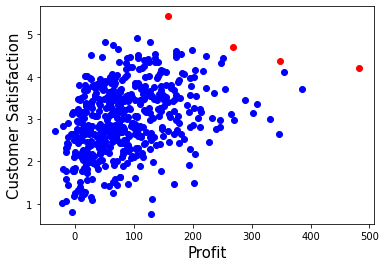

KeyboardInterrupt: 

In [20]:
if __name__ == "__main__":
    main()